In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Mounted at /content/drive


In [2]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('/content/drive/MyDrive/PTDL/Dataset/VCB.csv')
df=df.reset_index()['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 6s 48ms/step - loss: 0.0486 - val_loss: 0.0070
Epoch 2/100
12/12 [==============================] - 0s 28ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 3/100
12/12 [==============================] - 0s 29ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 4/100
12/12 [==============================] - 0s 28ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 5/100
12/12 [==============================] - 0s 27ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 6/100
12/12 [==============================] - 0s 28ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 7/100
12/12 [==============================] - 0s 27ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 8/100
12/12 [==============================] - 0s 27ms/step - loss: 9.6082e-04 - val_loss: 0.0016
Epoch 9/100
12/12 [==============================] - 1s 46ms/step - loss: 9.3101e-04 - val_loss: 0.0015
Epoch 10/100
12/12 [==============================] - 1s 44ms/step - loss: 8.7950e-04 - val_

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 24ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
train_size1 = int(0.7 * len(df))
test_size1 = int(0.2 * len(df))

train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]

x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1)

In [13]:
# 12. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val1)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val1 - y_pred_val) / y_val1)) * 100
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val1))
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 6895.603846980391
Testing RMSE: 7455.522083927794
Validation MAPE: 6.302653951445866
Testing MAPE: 7.3701876719010935
Validation MAE: 5171.64221875
Testing MAE: 5848.457269550966


In [22]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[len(val_data)-time_step:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=99
i=0
while(i<30):

    if(len(temp_input)>99):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.69745195 0.70794495 0.70444728 0.70094962 0.70444728 0.72018678
 0.7324286  0.72018678 0.76565642 0.76915409 0.79014008 0.79014008
 0.84085623 0.84785156 0.80937724 0.80413074 0.82161907 0.84785156
 0.88457704 0.89507004 0.94753502 0.94753502 0.89332121 0.92829786
 0.87933055 0.90556304 0.94753502 1.         0.93004669 0.96852101
 0.94753502 0.97376751 0.95627918 0.93879086 0.94753502 0.93704202
 0.94753502 0.96152568 0.96852101 0.94753502 0.95278152 0.95627918
 0.94403736 0.95627918 0.94753502 0.95103269 0.91080953 0.91255837
 0.92829786 0.93354436 0.94753502 0.93179553 0.92130253 0.91255837
 0.9195537  0.91255837 0.87758171 0.80937724 0.8338609  0.87758171
 0.90731187 0.87758171 0.91255837 0.92654903 0.93529319 0.94228852
 0.9195537  0.94403736 0.93004669 0.93179553 0.91605603 0.89507004
 0.87758171 0.86359105 0.86533989 0.86359105 0.86708872 0.86708872
 0.86009339 0.86883755 0.86533989 0.85134922 0.85834456 0.86533989
 0.88457704 0.89507004 0.9038142  0.86883755 0.891

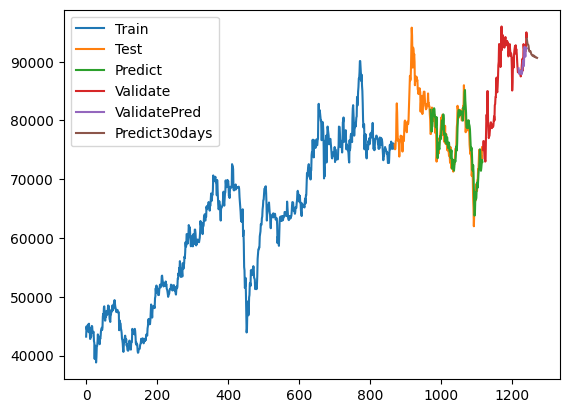

In [23]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()